In [2]:
import os 
import json
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from random import shuffle, choices
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    hamming_loss,
)

from GRU_pipeline import DataHolder, paths, MultiModalDicDataset, GRUModel, pad_collate, eval_on_val, train_one_epoch
from models import GRUMultiModal, GRUBiModal, BertClassif

/Users/ewenmichel/miniconda3/envs/altegrad/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DH = DataHolder(**paths, none_as_class=True)

train_test_1 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 1, none_count = 2000, test_size = .15, val_size = .17)
train_test_2 = DH.stratified_train_test_split(feature = 'multimodal', speaker = 2, none_count = 2000, test_size = .15, val_size = .17)

class_weights = train_test_1['class_weights']
class_weights = torch.Tensor([(1 - x) ** 2 for x in class_weights])

train_dataset_1 = MultiModalDicDataset(**train_test_1['data'])
test_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["test_dic_openface"], train_dic_opensmile = train_test_1["data"]["test_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_1 = MultiModalDicDataset(train_dic_openface = train_test_1["data"]["valid_dic_openface"], train_dic_opensmile = train_test_1["data"]["valid_dic_opensmile"], features_openface = train_test_1["data"]["features_openface"], features_opensmile = train_test_1["data"]["features_opensmile"], embeds = train_test_1["data"]["embeds"], targets = train_test_1["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_1 = DataLoader(train_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_1 = DataLoader(val_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_1 = DataLoader(test_dataset_1, batch_size = 200, shuffle = True, collate_fn = pad_collate)

train_dataset_2 = MultiModalDicDataset(**train_test_2['data'])
test_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["test_dic_openface"], train_dic_opensmile = train_test_2["data"]["test_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)
val_dataset_2 = MultiModalDicDataset(train_dic_openface = train_test_2["data"]["valid_dic_openface"], train_dic_opensmile = train_test_2["data"]["valid_dic_opensmile"], features_openface = train_test_2["data"]["features_openface"], features_opensmile = train_test_2["data"]["features_opensmile"], embeds = train_test_2["data"]["embeds"], targets = train_test_2["data"]["targets"], test_dic_openface = None, test_dic_opensmile = None)

train_loader_2 = DataLoader(train_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
val_loader_2 = DataLoader(val_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)
test_loader_2 = DataLoader(test_dataset_2, batch_size = 200, shuffle = True, collate_fn = pad_collate)

In [87]:
multi_modal_params = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":2, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":2, 
            "output_dim":6, 
            "dropout_prob":.1,
            "activation":"softmax"}
AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":2, "output_dim":6, "dropout_prob":.1, "activation":"softmax"}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":2, "output_dim":6, "dropout_prob":.1, "activation":"softmax"}
TEXTPARAMS = {"embeddings_dim" : 768, "hidden_dim" : 768, "output_dim" : 6, "activation":"softmax"}

multi_modal_model = GRUMultiModal(**multi_modal_params)
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
txt_model = BertClassif(**TEXTPARAMS)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params = video_model.parameters(), lr = 5e-5)

EPOCHS = 500

hist_train_loss = []
hist_val_loss = []
device = torch.device("mps")
model_l = [multi_modal_model, audio_model, video_model, txt_model] #
modality_l = ["", "audio", "video", ""] # 

save_dir = "2layer-32hiddendim-6class-softmax-42/"

if not os.path.isdir("models/" + save_dir):
    os.mkdir("models/" + save_dir)

for model_, modality_ in zip(model_l, modality_l):
    stagnation= 0
    best_vloss = 1000
    optimizer = torch.optim.Adam(params = model_.parameters(), lr = 3e-5)
    for epoch in tqdm(range(EPOCHS), total = EPOCHS):

        curr_train_loss, curr_val_loss = hist_train_loss, hist_val_loss
        if epoch % 30 == 0:
            print("EPOCH {}:".format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        video_model.train(True)
        hist_train_loss, hist_val_loss, stagnation, best_vloss = train_one_epoch(
            epoch, model_, criterion, train_loader_1, train_loader_2, val_loader_1, val_loader_2, hist_train_loss, hist_val_loss, stagnation, best_vloss, opt = optimizer, modality = modality_, save_dir = "models/" + save_dir
        )

        if stagnation > 4:
            break

  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


/Users/ewenmichel/Desktop/Centrale/3A/SDI/Project/Multimodal-CSC/models.py:864: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.activation(out)
  0%|          | 1/500 [00:50<6:59:20, 50.42s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 2.2592408657073975, Val loss = 2.245842933654785


  6%|▌         | 30/500 [02:53<32:59,  4.21s/it] 

EPOCH 31:


  6%|▌         | 31/500 [02:56<31:32,  4.04s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7098069190979004, Val loss = 0.7396520972251892


 12%|█▏        | 60/500 [05:02<30:39,  4.18s/it]

EPOCH 61:


 12%|█▏        | 61/500 [05:06<30:19,  4.14s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.35131174325942993, Val loss = 0.4119277000427246


 18%|█▊        | 90/500 [06:59<25:29,  3.73s/it]

EPOCH 91:


 18%|█▊        | 91/500 [07:03<26:30,  3.89s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.2078619748353958, Val loss = 0.26681238412857056


 24%|██▍       | 120/500 [09:01<26:55,  4.25s/it]

EPOCH 121:


 24%|██▍       | 121/500 [09:05<26:36,  4.21s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.16885773837566376, Val loss = 0.23102223873138428


 30%|███       | 150/500 [11:25<25:37,  4.39s/it]

EPOCH 151:


 30%|███       | 151/500 [11:29<25:31,  4.39s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.14768947660923004, Val loss = 0.20187364518642426


 36%|███▌      | 180/500 [13:34<24:02,  4.51s/it]

EPOCH 181:


 36%|███▌      | 181/500 [13:39<24:21,  4.58s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.11043918877840042, Val loss = 0.19410340487957


 42%|████▏     | 210/500 [15:45<20:56,  4.33s/it]

EPOCH 211:


 42%|████▏     | 211/500 [15:50<21:43,  4.51s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.09581763297319412, Val loss = 0.20109595358371735


 48%|████▊     | 240/500 [18:24<19:49,  4.57s/it]

EPOCH 241:


 48%|████▊     | 241/500 [18:28<19:33,  4.53s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.08135553449392319, Val loss = 0.21744099259376526


 54%|█████▍    | 270/500 [20:36<15:37,  4.08s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [20:40<15:24,  4.04s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.06573033332824707, Val loss = 0.21626515686511993


 60%|██████    | 300/500 [22:42<17:41,  5.31s/it]

EPOCH 301:


 60%|██████    | 301/500 [22:52<21:59,  6.63s/it]

EPOCH 301:
Training epoch 300 :
Train loss = 0.05513154715299606, Val loss = 0.2111222743988037


 66%|██████▌   | 330/500 [25:05<13:20,  4.71s/it]

EPOCH 331:


 66%|██████▌   | 330/500 [25:09<12:57,  4.57s/it]


EPOCH 331:
Training epoch 330 :
Train loss = 0.041859131306409836, Val loss = 0.26035627722740173


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


/Users/ewenmichel/Desktop/Centrale/3A/SDI/Project/Multimodal-CSC/models.py:921: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.activation(out)
  0%|          | 1/500 [00:01<16:03,  1.93s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 2.2785699367523193, Val loss = 2.2834506034851074


  6%|▌         | 30/500 [01:02<15:52,  2.03s/it]

EPOCH 31:


  6%|▌         | 31/500 [01:04<16:10,  2.07s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7305973768234253, Val loss = 0.7487359046936035


 12%|█▏        | 60/500 [02:02<13:58,  1.91s/it]

EPOCH 61:


 12%|█▏        | 61/500 [02:04<13:56,  1.91s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.3776778280735016, Val loss = 0.44347378611564636


 18%|█▊        | 90/500 [03:02<13:08,  1.92s/it]

EPOCH 91:


 18%|█▊        | 91/500 [03:04<13:22,  1.96s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.229589581489563, Val loss = 0.28410765528678894


 24%|██▍       | 120/500 [04:05<12:34,  1.99s/it]

EPOCH 121:


 24%|██▍       | 121/500 [04:07<12:39,  2.00s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.17422205209732056, Val loss = 0.2499719262123108


 30%|███       | 150/500 [05:04<11:28,  1.97s/it]

EPOCH 151:


 30%|███       | 151/500 [05:06<11:32,  1.98s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.14226505160331726, Val loss = 0.21985670924186707


 36%|███▌      | 180/500 [06:25<18:00,  3.38s/it]

EPOCH 181:


 36%|███▌      | 181/500 [06:27<16:07,  3.03s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.13373509049415588, Val loss = 0.23627860844135284


 42%|████▏     | 210/500 [08:27<10:20,  2.14s/it]

EPOCH 211:


 42%|████▏     | 211/500 [08:28<09:54,  2.06s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.10537707060575485, Val loss = 0.22407414019107819


 48%|████▊     | 240/500 [09:36<09:27,  2.18s/it]

EPOCH 241:


 48%|████▊     | 241/500 [09:38<09:26,  2.19s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.09352133423089981, Val loss = 0.2338266372680664


 54%|█████▍    | 270/500 [10:45<08:39,  2.26s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [10:47<08:31,  2.23s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.0857749953866005, Val loss = 0.23493431508541107


 60%|██████    | 300/500 [11:52<07:34,  2.27s/it]

EPOCH 301:


 60%|██████    | 300/500 [11:55<07:56,  2.38s/it]


EPOCH 301:
Training epoch 300 :
Train loss = 0.07206396758556366, Val loss = 0.25951695442199707


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


  0%|          | 1/500 [00:02<17:38,  2.12s/it]

EPOCH 1:
Training epoch 0 :
Train loss = 2.3001766204833984, Val loss = 2.2976531982421875


  6%|▌         | 30/500 [01:09<20:00,  2.55s/it]

EPOCH 31:


  6%|▌         | 31/500 [01:12<19:15,  2.46s/it]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7351694703102112, Val loss = 0.7716291546821594


 12%|█▏        | 60/500 [02:23<20:17,  2.77s/it]

EPOCH 61:


 12%|█▏        | 61/500 [02:26<21:44,  2.97s/it]

EPOCH 61:
Training epoch 60 :
Train loss = 0.3787108361721039, Val loss = 0.43117737770080566


 18%|█▊        | 90/500 [03:39<16:17,  2.38s/it]

EPOCH 91:


 18%|█▊        | 91/500 [03:41<15:40,  2.30s/it]

EPOCH 91:
Training epoch 90 :
Train loss = 0.22664952278137207, Val loss = 0.2873886525630951


 24%|██▍       | 120/500 [04:39<12:42,  2.01s/it]

EPOCH 121:


 24%|██▍       | 121/500 [04:40<12:25,  1.97s/it]

EPOCH 121:
Training epoch 120 :
Train loss = 0.16671761870384216, Val loss = 0.23606669902801514


 30%|███       | 150/500 [05:40<12:04,  2.07s/it]

EPOCH 151:


 30%|███       | 151/500 [05:43<11:59,  2.06s/it]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1362793743610382, Val loss = 0.21014876663684845


 36%|███▌      | 180/500 [06:43<10:59,  2.06s/it]

EPOCH 181:


 36%|███▌      | 181/500 [06:45<11:02,  2.08s/it]

EPOCH 181:
Training epoch 180 :
Train loss = 0.11786425858736038, Val loss = 0.2049299031496048


 42%|████▏     | 210/500 [07:47<10:08,  2.10s/it]

EPOCH 211:


 42%|████▏     | 211/500 [07:49<10:09,  2.11s/it]

EPOCH 211:
Training epoch 210 :
Train loss = 0.10737979412078857, Val loss = 0.21337862312793732


 48%|████▊     | 240/500 [08:49<08:55,  2.06s/it]

EPOCH 241:


 48%|████▊     | 241/500 [08:51<08:57,  2.07s/it]

EPOCH 241:
Training epoch 240 :
Train loss = 0.09125544875860214, Val loss = 0.2169981151819229


 54%|█████▍    | 270/500 [09:52<07:57,  2.08s/it]

EPOCH 271:


 54%|█████▍    | 271/500 [09:54<07:58,  2.09s/it]

EPOCH 271:
Training epoch 270 :
Train loss = 0.0702597051858902, Val loss = 0.23236022889614105


 60%|██████    | 300/500 [10:57<06:58,  2.09s/it]

EPOCH 301:


 60%|██████    | 301/500 [10:58<06:44,  2.03s/it]

EPOCH 301:
Training epoch 300 :
Train loss = 0.05726359784603119, Val loss = 0.2535478472709656


 66%|██████▌   | 330/500 [12:08<08:29,  2.99s/it]

EPOCH 331:


 66%|██████▌   | 330/500 [12:11<06:16,  2.22s/it]


EPOCH 331:
Training epoch 330 :
Train loss = 0.04590389132499695, Val loss = 0.24347682297229767


  0%|          | 0/500 [00:00<?, ?it/s]

EPOCH 1:


/Users/ewenmichel/Desktop/Centrale/3A/SDI/Project/Multimodal-CSC/models.py:957: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.activation(out)
  0%|          | 1/500 [00:00<03:06,  2.67it/s]

EPOCH 1:
Training epoch 0 :
Train loss = 2.2196, Val loss = 2.2109


  6%|▌         | 30/500 [00:14<05:56,  1.32it/s]

EPOCH 31:


  6%|▌         | 31/500 [00:15<05:30,  1.42it/s]

EPOCH 31:
Training epoch 30 :
Train loss = 0.7078, Val loss = 0.7323


 12%|█▏        | 60/500 [00:27<02:04,  3.55it/s]

EPOCH 61:


 12%|█▏        | 61/500 [00:28<02:05,  3.50it/s]

EPOCH 61:
Training epoch 60 :
Train loss = 0.3472, Val loss = 0.4213


 18%|█▊        | 90/500 [00:36<01:55,  3.56it/s]

EPOCH 91:


 18%|█▊        | 91/500 [00:36<01:57,  3.49it/s]

EPOCH 91:
Training epoch 90 :
Train loss = 0.2218, Val loss = 0.2752


 24%|██▍       | 120/500 [00:45<01:48,  3.52it/s]

EPOCH 121:


 24%|██▍       | 121/500 [00:45<01:48,  3.49it/s]

EPOCH 121:
Training epoch 120 :
Train loss = 0.1714, Val loss = 0.2446


 30%|███       | 150/500 [00:53<01:41,  3.45it/s]

EPOCH 151:


 30%|███       | 151/500 [00:54<01:40,  3.47it/s]

EPOCH 151:
Training epoch 150 :
Train loss = 0.1399, Val loss = 0.2164


 36%|███▌      | 180/500 [01:03<02:01,  2.64it/s]

EPOCH 181:


 36%|███▌      | 181/500 [01:03<01:56,  2.73it/s]

EPOCH 181:
Training epoch 180 :
Train loss = 0.1200, Val loss = 0.2209


 42%|████▏     | 210/500 [01:15<02:20,  2.06it/s]

EPOCH 211:


 42%|████▏     | 211/500 [01:15<02:09,  2.23it/s]

EPOCH 211:
Training epoch 210 :
Train loss = 0.1059, Val loss = 0.2244


 48%|████▊     | 240/500 [01:29<01:41,  2.55it/s]

EPOCH 241:


 48%|████▊     | 241/500 [01:29<01:33,  2.76it/s]

EPOCH 241:
Training epoch 240 :
Train loss = 0.0923, Val loss = 0.2398


 54%|█████▍    | 270/500 [01:39<01:16,  2.99it/s]

EPOCH 271:


 54%|█████▍    | 271/500 [01:40<01:13,  3.10it/s]

EPOCH 271:
Training epoch 270 :
Train loss = 0.0777, Val loss = 0.2197


 60%|██████    | 300/500 [01:48<00:58,  3.44it/s]

EPOCH 301:


 60%|██████    | 300/500 [01:49<01:12,  2.75it/s]

EPOCH 301:
Training epoch 300 :
Train loss = 0.0702, Val loss = 0.2595


In [5]:
multi_modal_params = {"embeddings_dim" : 768, 
            "audio_input_dim":23, 
            "audio_hidden_dim":32, 
            "audio_layer_dim":3, 
            "video_input_dim":17, 
            "video_hidden_dim":32, 
            "video_layer_dim":3, 
            "output_dim":6, 
            "dropout_prob":.1,
            "activation":"sigmoid"}

AUDIOPARAMS = {"embeddings_dim" : 768, "input_dim":23, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1, "activation":"sigmoid"}
VIDEOPARAMS = {"embeddings_dim" : 768, "input_dim":17, "hidden_dim":32, "layer_dim":3, "output_dim":6, "dropout_prob":.1, "activation":"sigmoid"}
TEXTPARAMS = {"embeddings_dim" : 768, "hidden_dim" : 768, "output_dim": 6, "activation":"sigmoid"}

multi_modal_model = GRUMultiModal(**multi_modal_params)
audio_model = GRUBiModal(**AUDIOPARAMS)
video_model = GRUBiModal(**VIDEOPARAMS)
txt_model = BertClassif(**TEXTPARAMS)

path = "models/3layer-32hiddendim-6class-sigmoid-42/"

multi_modal_model.load_state_dict(torch.load(path + "MultiModalBert"))
video_model.load_state_dict(torch.load(path + "BertvideoBimodal"))
audio_model.load_state_dict(torch.load(path + "BertaudioBimodal"))
txt_model.load_state_dict(torch.load(path + "BertClassif"))

<All keys matched successfully>

In [6]:
fin_targets = []
txt_fin_outputs = []
audio_fin_outputs = []
video_fin_outputs = []
multimodal_fin_outputs = []

for j, batch in tqdm(enumerate(test_loader_1)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multi_modal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())

for j, batch in tqdm(enumerate(test_loader_2)):
    features_of, features_os, embeds, targets = batch['features_of'], batch['features_os'], batch['embeds'], batch['targets']
    text_pred = txt_model(embeds)
    audio_pred = audio_model(embeds, features_os)
    video_pred = video_model(embeds, features_of)
    multimodal_pred = multi_modal_model(embeds, features_os, features_of)
    fin_targets.extend(targets.cpu().detach().numpy().tolist())
    txt_fin_outputs.extend(np.array(text_pred.cpu().detach().numpy()).tolist())
    audio_fin_outputs.extend(np.array(audio_pred.cpu().detach().numpy()).tolist())
    video_fin_outputs.extend(np.array(video_pred.cpu().detach().numpy()).tolist())
    multimodal_fin_outputs.extend(np.array(multimodal_pred.cpu().detach().numpy()).tolist())
    
y_true = np.asarray(fin_targets)
txt_pred_n = np.asarray(txt_fin_outputs)
audio_pred_n = np.asarray(audio_fin_outputs)
video_pred_n = np.asarray(video_fin_outputs)
multimodal_pred_n = np.asarray(multimodal_fin_outputs)

2it [00:00,  4.86it/s]
2it [00:00,  9.00it/s]


In [17]:
np.save(path + "txt_pred_n", txt_pred_n)
np.save(path + "audio_pred_n", audio_pred_n)
np.save(path + "video_pred_n", video_pred_n)
np.save(path + "multimodal_pred_n", multimodal_pred_n)
np.save(path + "y_true", y_true)

In [19]:
np.save("y_true", y_true)

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
import seaborn as sns
# auc scores
auc_score1 = roc_auc_score(y_true, txt_pred_n)
auc_score2 = roc_auc_score(y_true, audio_pred_n)
auc_score3 = roc_auc_score(y_true, video_pred_n)
auc_score4 = roc_auc_score(y_true, multimodal_pred_n)

print(auc_score1, auc_score2, auc_score3, auc_score4)

0.9807672463128784 0.9838098397685978 0.9824444842654868 0.9852533250620493


==============text===============
              precision    recall  f1-score   support

          SD       0.63      0.90      0.75        63
          QE       0.71      0.86      0.77        14
          SV       0.00      0.00      0.00         8
          PR       0.75      0.50      0.60        12
          HD       0.68      0.87      0.77        62
        None       0.99      1.00      1.00       601

   micro avg       0.91      0.96      0.94       760
   macro avg       0.63      0.69      0.65       760
weighted avg       0.92      0.96      0.94       760
 samples avg       0.94      0.97      0.95       760



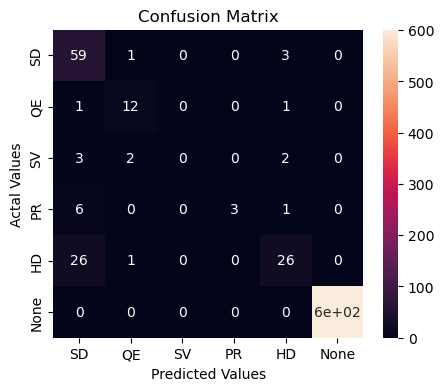

==============multimodal===============
              precision    recall  f1-score   support

          SD       0.67      0.87      0.76        63
          QE       0.75      0.86      0.80        14
          SV       0.12      0.12      0.12         8
          PR       0.53      0.67      0.59        12
          HD       0.75      0.85      0.80        62
        None       1.00      1.00      1.00       601

   micro avg       0.92      0.96      0.94       760
   macro avg       0.64      0.73      0.68       760
weighted avg       0.93      0.96      0.94       760
 samples avg       0.95      0.97      0.95       760



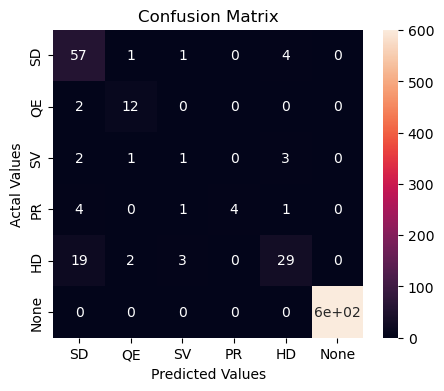

==============video===============
              precision    recall  f1-score   support

          SD       0.65      0.86      0.74        63
          QE       0.75      0.86      0.80        14
          SV       0.25      0.25      0.25         8
          PR       0.54      0.58      0.56        12
          HD       0.65      0.85      0.74        62
        None       1.00      1.00      1.00       601

   micro avg       0.91      0.96      0.93       760
   macro avg       0.64      0.73      0.68       760
weighted avg       0.92      0.96      0.94       760
 samples avg       0.94      0.97      0.95       760



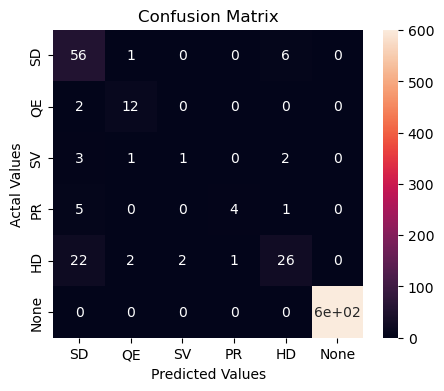

==============audio===============
              precision    recall  f1-score   support

          SD       0.67      0.92      0.77        63
          QE       0.75      0.86      0.80        14
          SV       0.00      0.00      0.00         8
          PR       0.67      0.50      0.57        12
          HD       0.71      0.85      0.77        62
        None       1.00      1.00      1.00       601

   micro avg       0.92      0.96      0.94       760
   macro avg       0.63      0.69      0.65       760
weighted avg       0.93      0.96      0.94       760
 samples avg       0.94      0.97      0.95       760



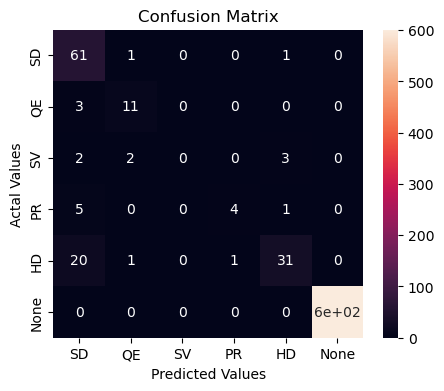

In [9]:
y_true = np.asarray(fin_targets)
txt_pred_n = np.asarray(txt_fin_outputs)
audio_pred_n = np.asarray(audio_fin_outputs)
video_pred_n = np.asarray(video_fin_outputs)
multimodal_pred_n = np.asarray(multimodal_fin_outputs)

results = [txt_pred_n, multimodal_pred_n, audio_pred_n, video_pred_n]
names = ["text", "multimodal", "video", "audio"]

# none_true = np.maximum(0, 1 - y_true.sum(axis = 1).reshape(-1, 1))
# y_true = np.concatenate([y_true, none_true], axis = 1)

for pred, n in zip(results, names):
    pred_final = np.where(pred > .2, 1, 0)
    # none_pred = np.maximum(0, 1 - pred_final.sum(axis = 1).reshape(-1, 1))
    
    # pred_final = np.concatenate([pred_final, none_pred], axis = 1)
    print("=============="  +n + "===============")
    print(classification_report(y_true, pred_final, target_names = ['SD', 'QE', 'SV', 'PR', 'HD', "None"], zero_division = False))
    cm = confusion_matrix(np.argmax(y_true, axis = 1), np.argmax(pred_final, axis = 1))
    cm_df = pd.DataFrame(cm,
                     index = ['SD', 'QE', 'SV', 'PR', 'HD', 'None'], 
                     columns = ['SD', 'QE', 'SV', 'PR', 'HD', 'None'])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [10]:
def explore_tresh_comparison(true_model_1, pred_model_1, true_model_2, pred_model_2):
    tresh = np.linspace(pred_model_1.min()-.1,pred_model_1.max()+.1,100)
    out = [(
        np.subtract(precision_score(true_model_1, np.where(pred_model_1>t,1,0), zero_division = False), precision_score(true_model_2, np.where(pred_model_2>t,1,0), zero_division = False)),
        np.subtract(recall_score(true_model_1, np.where(pred_model_1>t,1,0)), recall_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(f1_score(true_model_1, np.where(pred_model_1>t,1,0)), f1_score(true_model_2, np.where(pred_model_2>t,1,0))),
        np.subtract(accuracy_score(true_model_1, np.where(pred_model_1>t, 1, 0)), accuracy_score(true_model_2, np.where(pred_model_2>t, 1, 0))),
        np.subtract(np.where(pred_model_1>t,1,0).sum() / pred_model_1.shape[0], np.where(pred_model_2>t,1,0).sum() / pred_model_2.shape[0]),
        true_model_1.sum()/true_model_1.shape[0]
    ) for t in tresh]
    out = pd.DataFrame(out, columns=['recall_score', 'precision_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh) #
    return out

# COMPARISON MULTI-MODAL VS. TEXT (POSITIVE VALUES ARE BETTER MULTI MODAL PERFORMANCES)

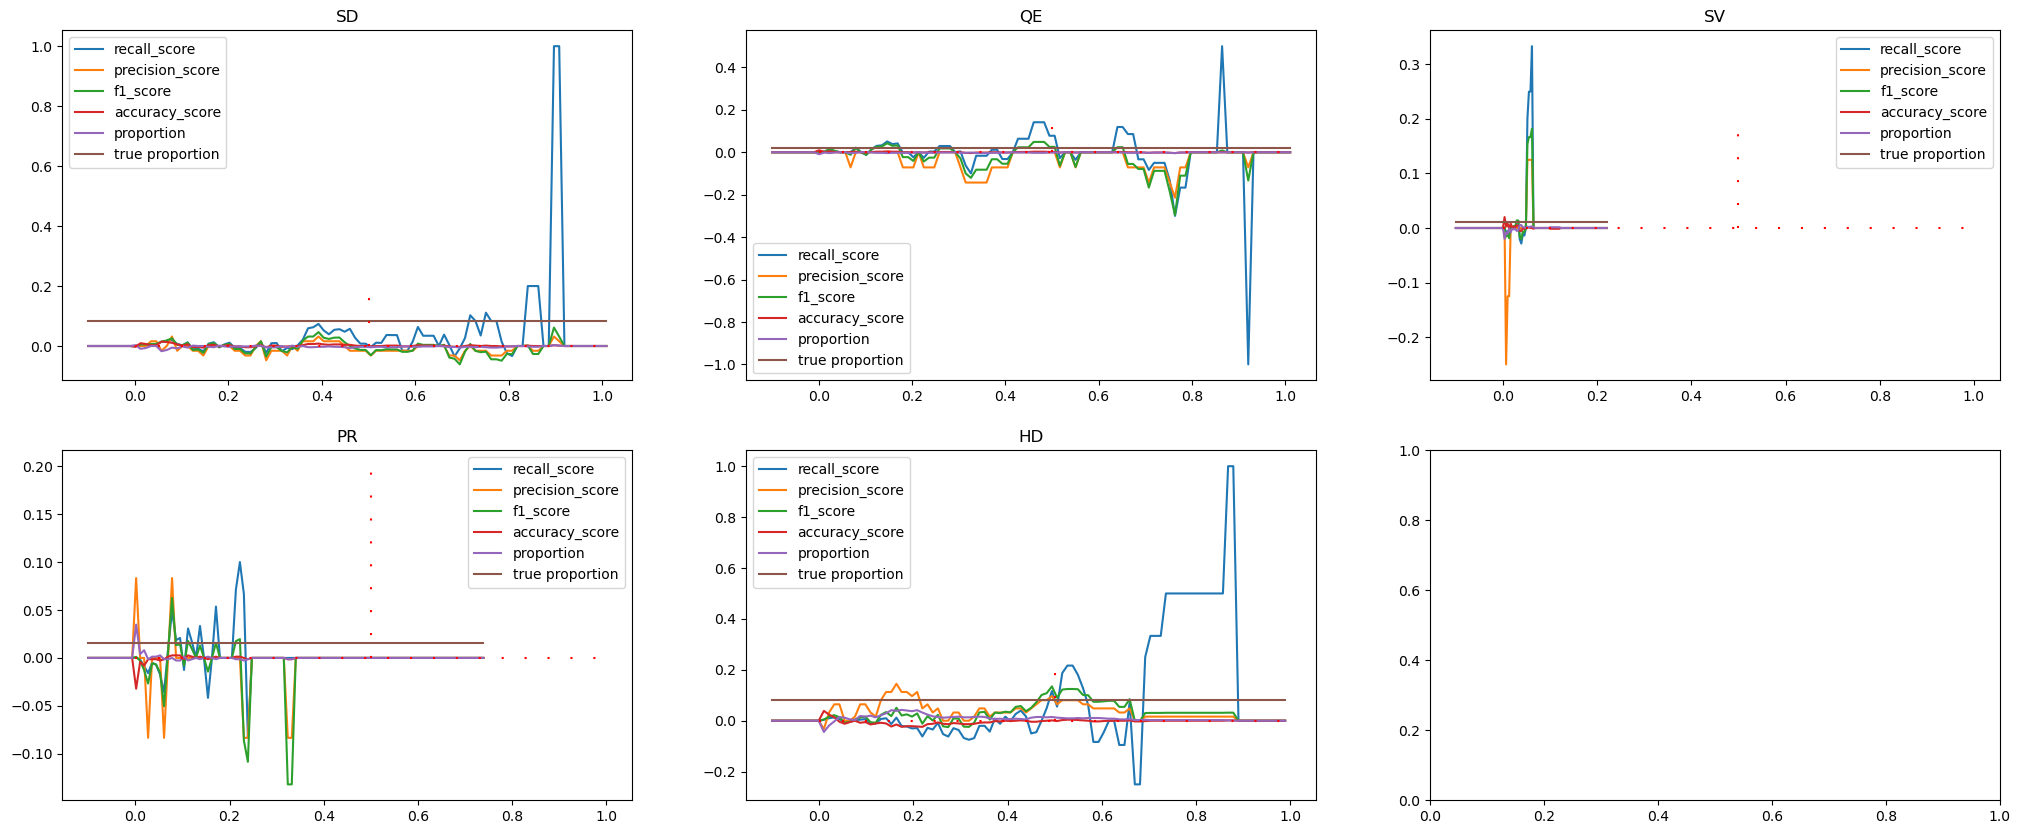

In [76]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh_comparison(y_true[:,i], multimodal_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

# COMPARISON AUDIO+TEXT VS. TEXT (POSITIVE VALUES -> AUDIO + TEXT BETTER)

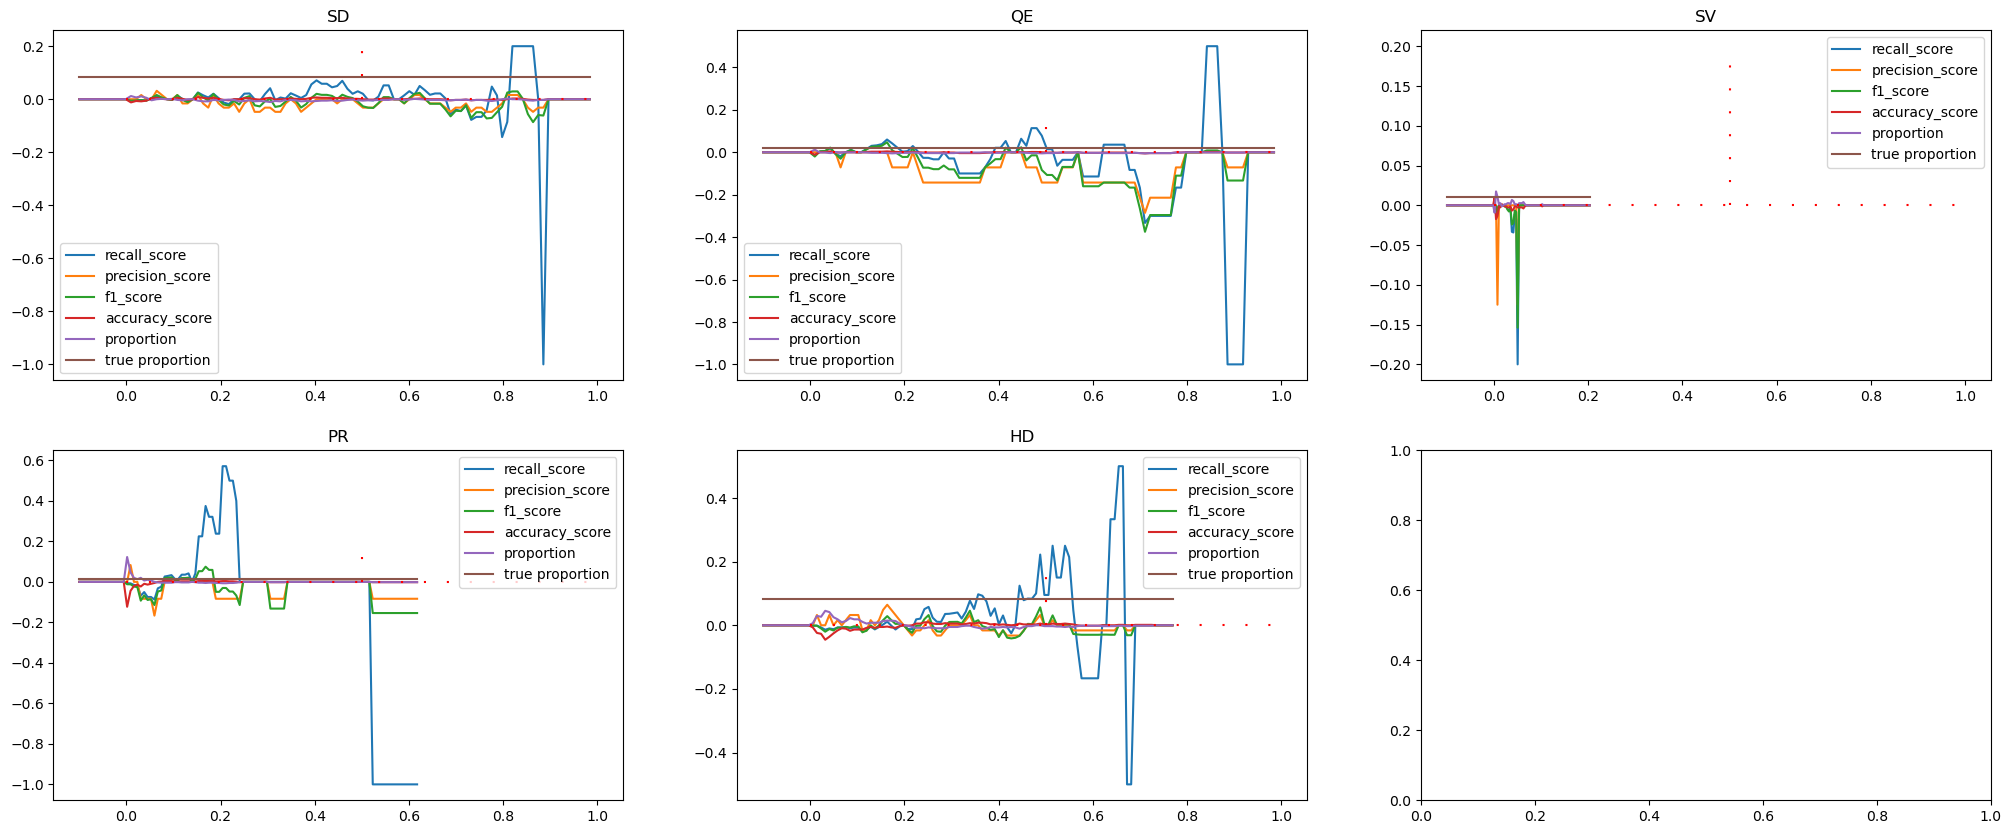

In [77]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh_comparison(y_true[:,i], audio_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

# COMPARISON VIDEO + TEXT VS. TEXT (positive is video + text > text)

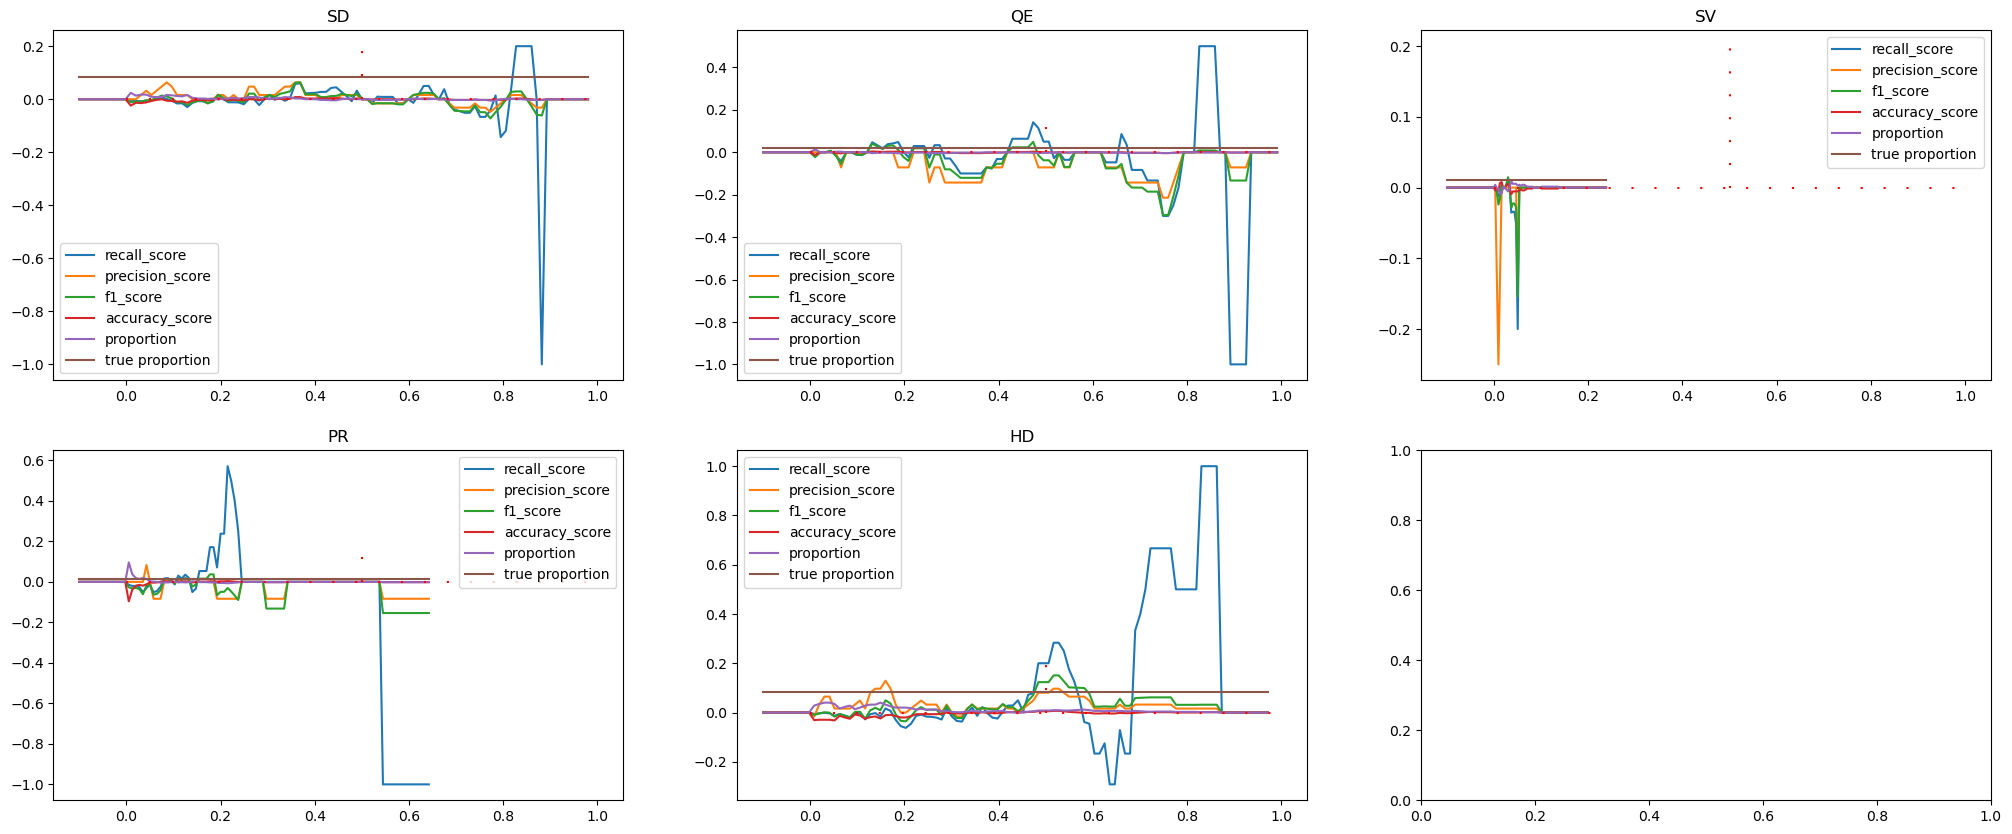

In [78]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh_comparison(y_true[:,i], video_pred_n[:,i], y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, .2, color = "red", linestyle = (0, (1, 10)))

# SINGLE MODEL PERFORMANCE

In [11]:
def explore_tresh(true, pred):
    prop=true.sum()/true.shape[0]
    tresh = np.linspace(pred.min(),pred.max(),100)
    out = [(
        accuracy_score(true, np.where(pred>t,1,0)),
        precision_score(true, np.where(pred>t,1,0), zero_division=1),
        recall_score(true, np.where(pred>t,1,0)),
        f1_score(true, np.where(pred>t,1,0)),
        chi2( np.where(pred>t,1,0).reshape(-1,1) , true )[1][0]
    ) for t in tresh[:-1]]
    out = pd.DataFrame(out, columns=['Accuracy', 'Precision', 'Recall', 'F1 score', '- .5 log p-value'], index=tresh[:-1])
    out['- .5 log p-value'] = - np.log10(out['- .5 log p-value']) / 40
    return out
# def explore_tresh(true, pred):
#     tresh = np.linspace(pred.min()-.1,pred.max()+.1,50)
#     out = [(
#         precision_score(true, np.where(pred>t,1,0), zero_division = False),
#         recall_score(true, np.where(pred>t,1,0)),
#         f1_score(true, np.where(pred>t,1,0)),
#         accuracy_score(true, np.where(pred>t, 1, 0)),
#         np.where(pred>t,1,0).sum() / pred.shape[0],
#         true.sum()/true.shape[0]
#     ) for t in tresh]
#     out = pd.DataFrame(out, columns=['precision_score', 'recall_score', 'f1_score', 'accuracy_score', 'proportion', 'true proportion'], index=tresh)
#     return out

### TEXT

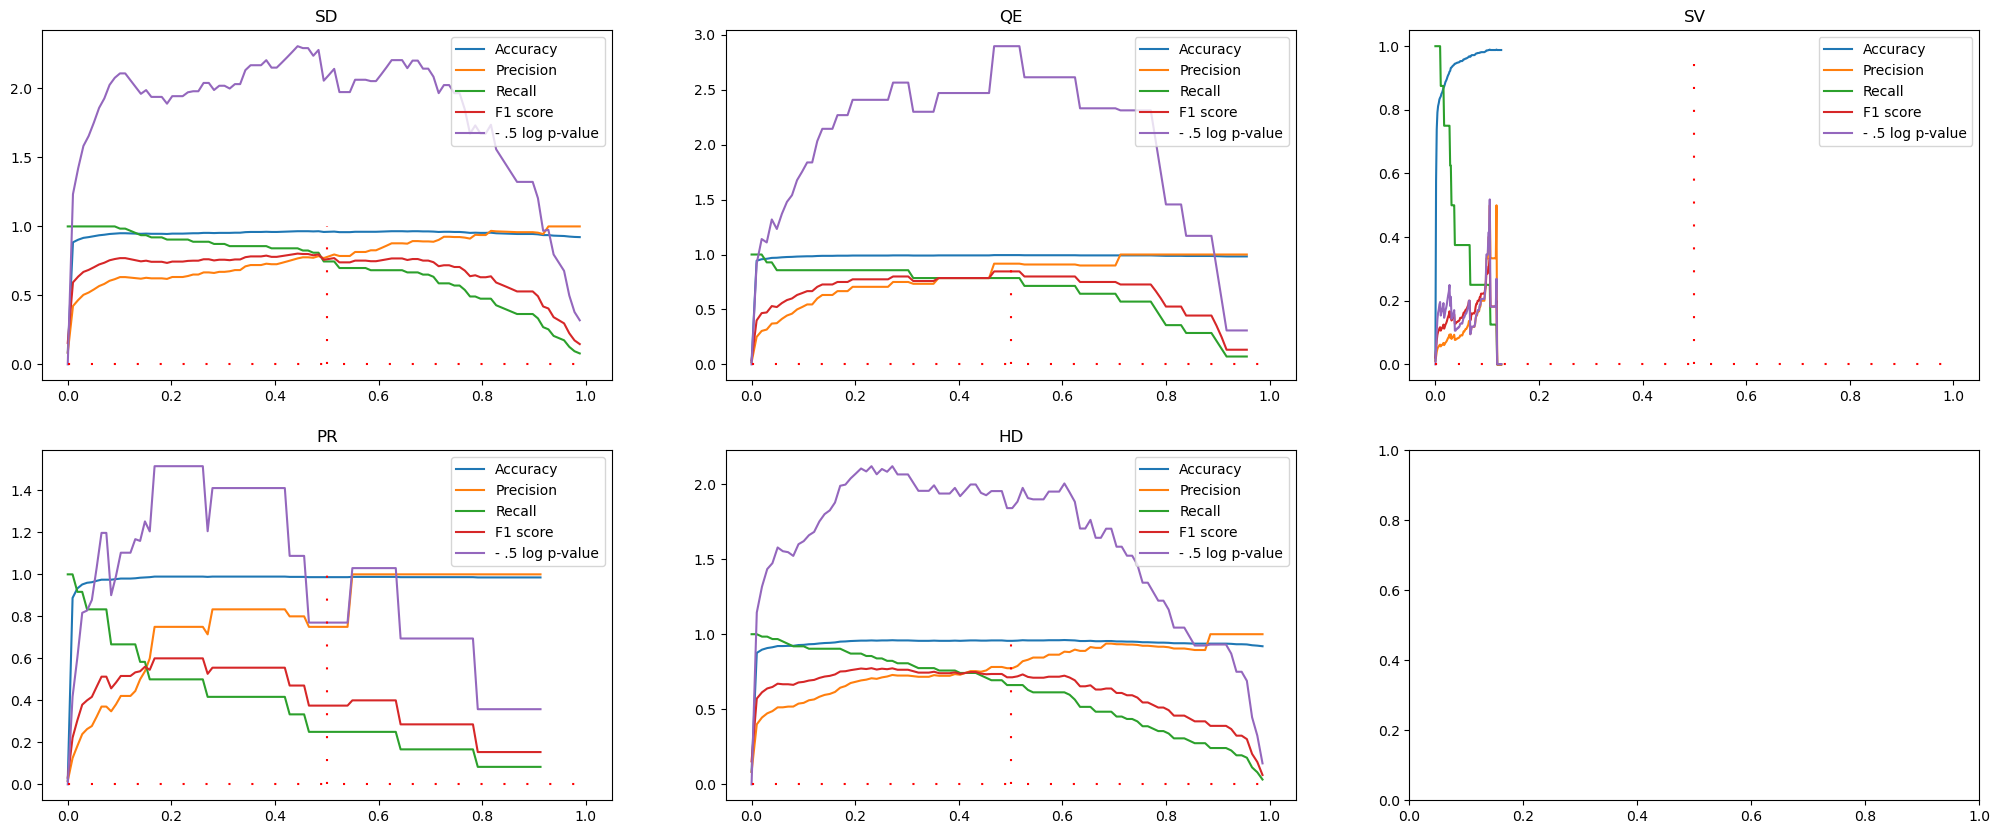

In [12]:
from sklearn.feature_selection import chi2

fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], txt_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))

# MULTI MODAL

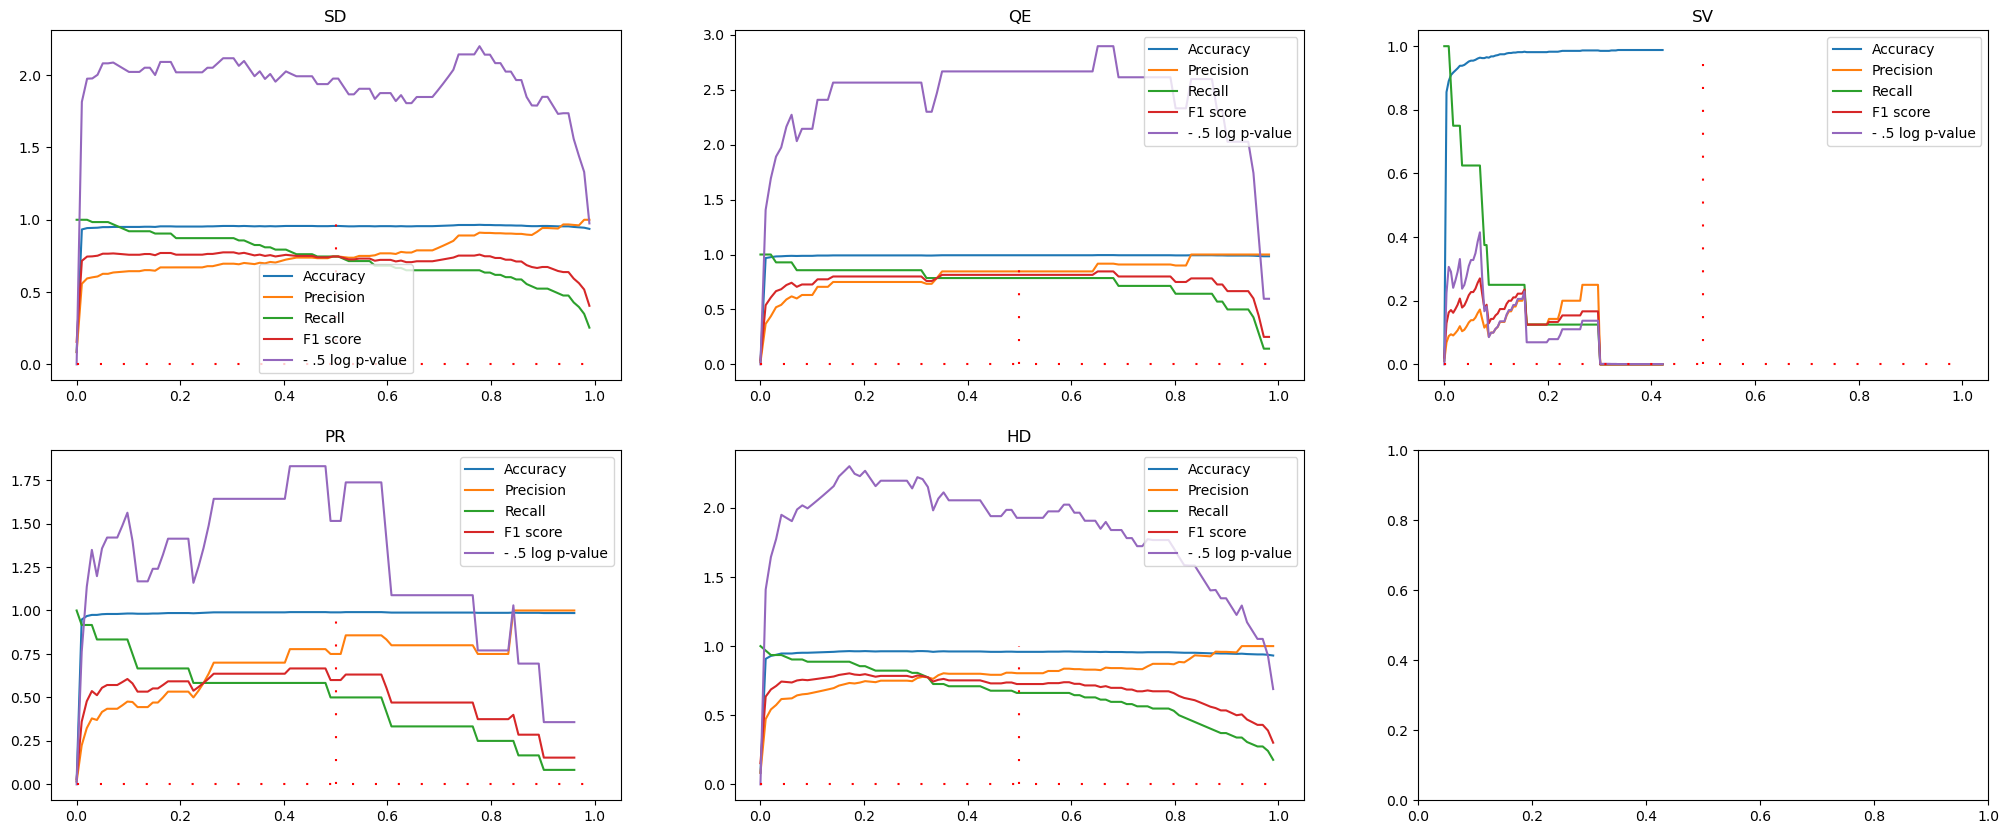

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], multimodal_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))

# AUDIO

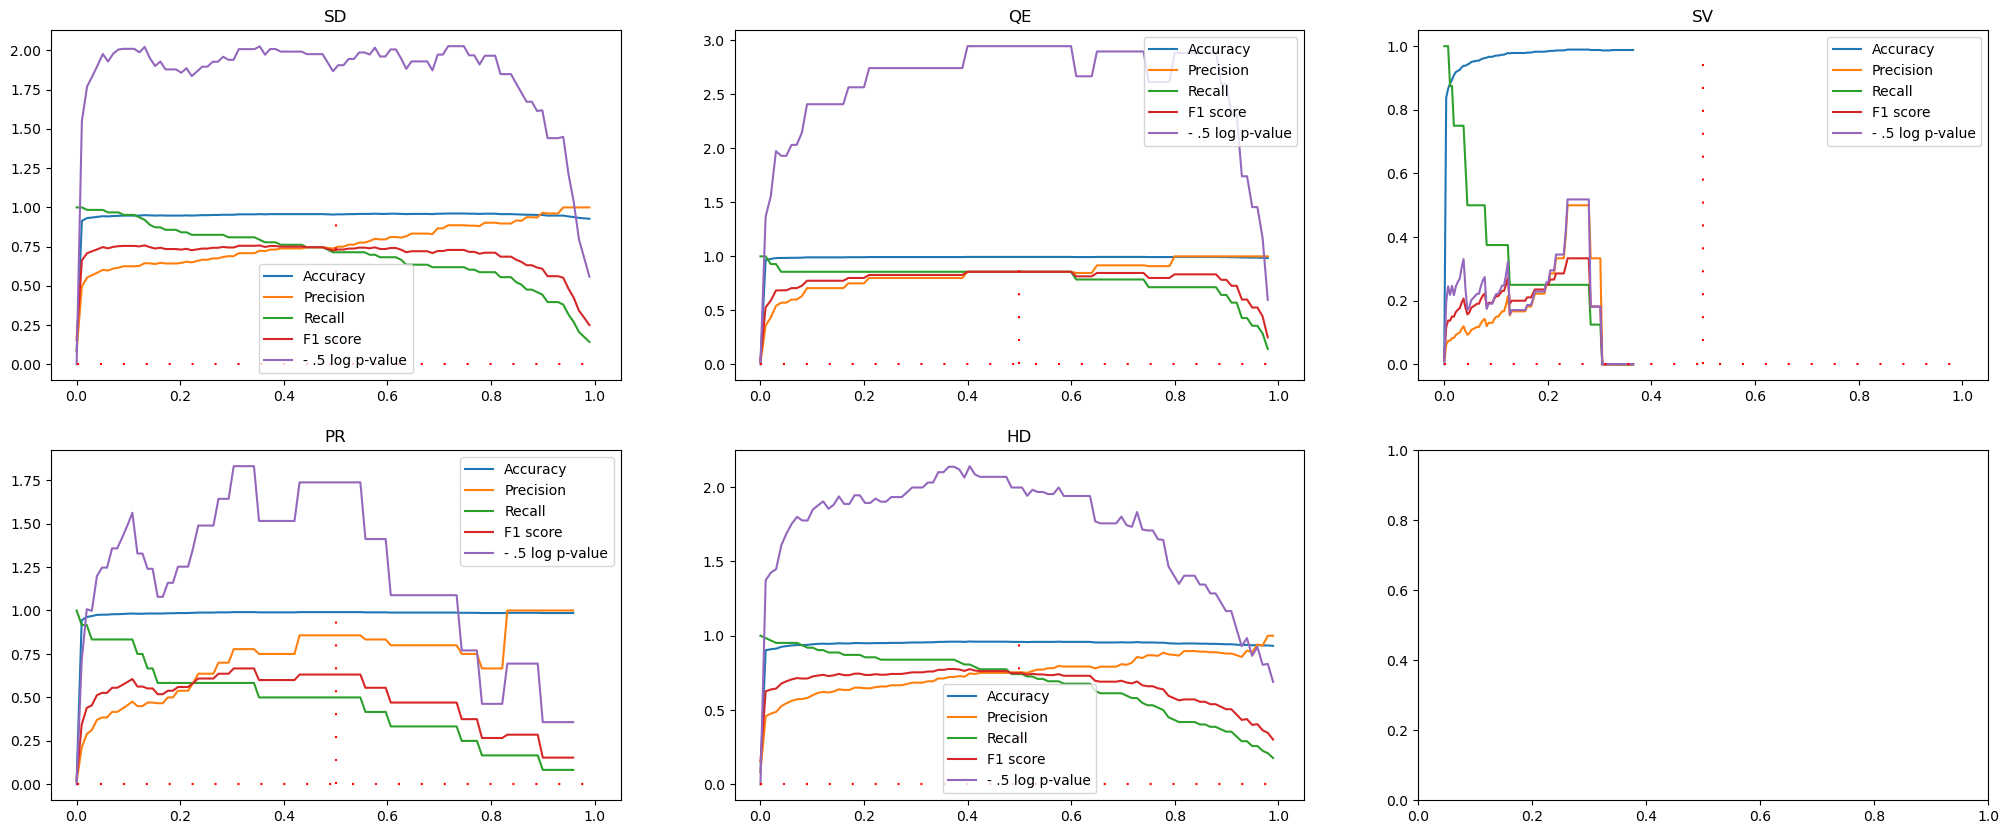

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], audio_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))

# VIDEO

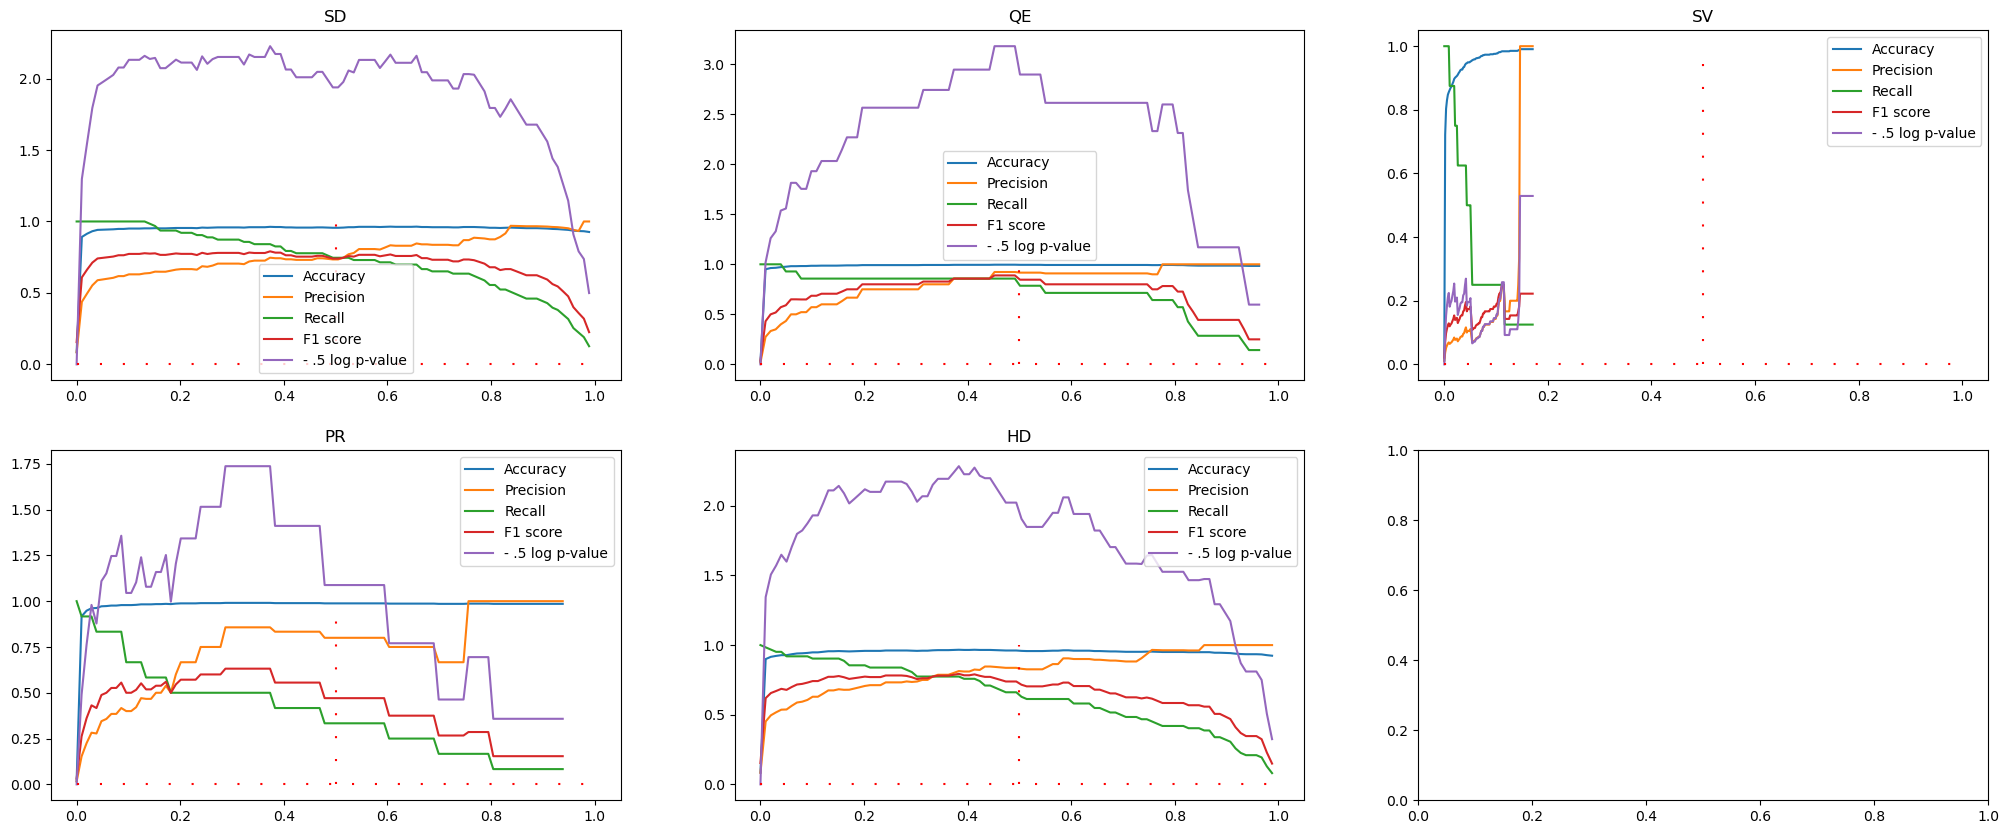

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(25)
cats = ['SD', 'QE', 'SV', 'PR', 'HD', "N"]
# df_pred = pd.DataFrame(pred_n_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
# df_true = pd.DataFrame(y_true_txt, columns = ['SD', 'QE', 'SV', 'PR', 'HD', "N"])
for i in range(5):
    explore_tresh(y_true[:,i], video_pred_n[:,i]).plot(ax = axes[int(i/3), (i % 3)], title = cats[i])
    axes[int(i/3), (i % 3)].hlines(0, 0, 1, color = "red", linestyle = (0, (1, 10)))
    axes[int(i/3), (i % 3)].vlines(0.5, 0, 1, color = "red", linestyle = (0, (1, 10)))